In [94]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [95]:
%matplotlib inline
import torch
import torch.nn as nn
import numba
import numpy as np
import matplotlib.pyplot as plt

In [161]:
spec = [
    ("solved", numba.types.boolean),
    ("g", numba.types.float64),
    ("mu", numba.types.float64),
    ("__v_no_drag", numba.types.float64[:]),
    ("__v", numba.types.float64[:]),
    ("__y_no_drag", numba.types.float64[:]),
    ("__y", numba.types.float64[:]),
    ("__t", numba.types.float64[:]),
]


@numba.jitclass(spec)
class ODEData:  # torch.utils.data.Dataset):
    def __init__(self, g=9.81, mu=0):
        self.solved = False
        self.g = g
        self.mu = mu

    def __getitem__(self, i):
        if not self.solved:
            raise RuntimeError("Please run solve() first!")
        return self.y_no_drag[i], self.y[i]

    def solve(self, v0, y0, t, dt):
        N = int(t // dt + 1)
        self.__v_no_drag = np.zeros(N)
        self.__y_no_drag = np.zeros_like(self.__v_no_drag)
        self.__v = np.zeros_like(self.__v_no_drag)
        self.__y = np.zeros_like(self.__v_no_drag)
        self.__v_no_drag[0] = self.__v[0] = v0
        self.__y_no_drag[0] = self.__y[0] = y0
        self.__t = np.linspace(0, t, N)
        for i in range(N - 1):
            a_pull = -self.g * self.__y[i]
            a_drag = self.mu * self.__v[i]
            a_pull_no_drag = -self.g * self.__y_no_drag[i]
            self.__v_no_drag[i + 1] = self.__v_no_drag[i] + min(a_pull_no_drag, 0) * dt
            self.__v[i + 1] = self.__v[i] + min(a_pull - a_drag, 0) * dt
            self.__y_no_drag[i + 1] = max(
                self.__y_no_drag[i] + self.__v_no_drag[i + 1] * dt, 0
            )
            self.__y[i + 1] = max(self.__y[i] + self.__v[i + 1] * dt, 0)
        self.solved = True

    @property
    def y(self):
        return self.__y

    @property
    def y_no_drag(self):
        return self.__y_no_drag

    @property
    def v(self):
        return self.__v

    @property
    def v_no_drag(self):
        return self.__v_no_drag

    @property
    def t(self):
        return self.__t

    @property
    def size(self):
        return len(self.__t)

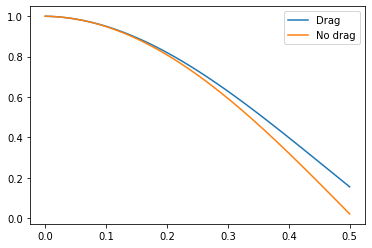

In [162]:
data = ODEData(mu=1)
data.solve(0, 1, 0.5, 0.01)
plt.plot(data.t, data.y, label="Drag")
plt.plot(data.t, data.y_no_drag, label="No drag")
plt.legend()
plt.show()

In [195]:
class HybridLSTM(nn.Module):
    def __init__(self, nodes=10, layers=1, dropout=0):
        super(HybridLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=nodes, num_layers=layers, dropout=dropout
        )
        self.output_layer = nn.Linear(nodes, 1)

    def forward(self, y):
        output, (h_n, c_n) = self.lstm(y)
        return self.output_layer(h_n[-1])

In [208]:
def train(net, data, lr=0.1, epochs=10):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
    loss_func = nn.MSELoss()
    net.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_no_drag = torch.zeros([data.size, 1, 1])
        y = torch.zeros_like(y_no_drag)
        net_correction = torch.zeros_like(y_no_drag)
        # loss = 0
        for i in range(data.size):
            tmp = torch.zeros_like(y)
            tmp2 = torch.zeros_like(y)
            tmp[i], tmp2[i] = data[i]
            y_no_drag = y_no_drag + tmp
            y = y + tmp2
            tmp = torch.zeros_like(y)
            tmp[i] = net.forward(y_no_drag[: i + 1])
            net_correction = net_correction + tmp
        loss = loss_func(net_correction + y_no_drag, y)
        print(f"Epoch {epoch}: {loss.item()}")
        loss.backward()
        optimizer.step()

In [209]:
net = HybridLSTM()
torch.autograd.set_detect_anomaly(False)
with torch.autograd.detect_anomaly():
    train(net, data)

Epoch 49: 0.09669739007949829
Epoch 49: 0.04809638112783432
Epoch 49: 0.02455192618072033


KeyboardInterrupt: 